# Graph Convolutional Networks (GCN)

Ref: https://antonsruberts.github.io/graph/gcn/

Nesse notebook será usado o pacote `stellargraph` [(docs)](https://stellargraph.readthedocs.io/en/stable/) e sua implementação de GCN. Os autores fornecem um bom exemplo de aplicacao usando jupyter [aqui](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html).

## Importando os pacotes

In [1]:
# !pip install stellargraph
# !pip uninstall umap -y
# !pip install umap-learn

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import json
import os
import umap.umap_ as umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

2022-02-08 15:37:32.359541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 15:37:32.366479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 15:37:32.366908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 15:37:32.368013: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

In [4]:
if tf.test.is_built_with_cuda():
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("TensorFlow wasn't built with CUDA (GPU) support")

Num GPUs Available:  1


## Dados
---

Vamos começar baixando o dataset de usuários do github, disponível [aqui](https://snap.stanford.edu/data/github-social.html).
Usaremos o dataset para classificar se o usuário é desenvolvedor web ou de ML.
Nesse dataset, os nós representam usuários do github que deram estrela para mais de 10 repositórios, as arestas representam seguidores em comum, e as características representam a localização, repositórios com estrelas, empregador e email.

### Baixando e extraindo o dataset

In [5]:
!wget -nc "https://snap.stanford.edu/data/git_web_ml.zip"
!unzip -o git_web_ml.zip

File ‘git_web_ml.zip’ already there; not retrieving.

Archive:  git_web_ml.zip
  inflating: git_web_ml/musae_git_edges.csv  
  inflating: git_web_ml/musae_git_features.json  
  inflating: git_web_ml/musae_git_target.csv  
  inflating: git_web_ml/citing.txt   
  inflating: git_web_ml/README.txt   


### Lendo as arestas, caracteristicas e rotulos

In [6]:
edges_path = './git_web_ml/musae_git_edges.csv'
targets_path = './git_web_ml/musae_git_target.csv'
features_path = './git_web_ml/musae_git_features.json'

### definindo um numero menor de amostras

Farei isso para treinar mais rapidamente e evitar erro de crash de memoria 

In [7]:
num_samples = 10000

In [8]:
# lendo as arestas
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility
display(edges.shape, edges.head())

(289003, 2)

,source,target
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [9]:
edges = edges[edges['target'] <num_samples]
edges = edges[edges['source'] <num_samples]
display(edges.shape, edges.head())

(18057, 2)

,source,target
2,1,2370
11,3,4950
13,3,3358
15,3,5916
16,4,2865


In [10]:
# lendo as caracteristicas
with open(features_path) as json_data:
    features = json.load(json_data)

max_feature = np.max([v for v_list in features.values() for v in v_list])
# features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1)) # Utiliza todo o sample
features_matrix = np.zeros(shape = (num_samples, max_feature+1))


i = 0
for k, vs in tqdm(features.items()):
    if i<num_samples:
    # if i<len(list(features.keys())): # Utiliza todo o sample
        for v in vs:
            features_matrix[i, v] = 1
        i+=1

  0%|          | 0/37700 [00:00<?, ?it/s]

In [11]:
# node_features = pd.DataFrame(features_matrix, index = features.keys())
node_features = pd.DataFrame(features_matrix, index = np.arange(num_samples).astype(str))
display(node_features.shape, node_features.head())

(10000, 4005)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# lendo os rotulos
targets = pd.read_csv(targets_path)
targets.index = targets.id.astype(str)
targets.drop('id', axis=1)
# targets.set_index('id', inplace=True)
targets = targets.loc[np.arange(num_samples).astype(str), :]
display(targets.shape, targets.head(), targets.ml_target.value_counts(normalize=True))

(10000, 3)

,id,name,ml_target
id,,,
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


0    0.7402
1    0.2598
Name: ml_target, dtype: float64

In [13]:
print("Então temos {} desenvolvedores, {} seguidores em comum e {} características. "
      "Aproximadamente {}% dos usuários são desenvolvedores web e {}% são desenvolvedores "
      "de ML."
.format(
    targets.shape[0],
    edges.shape[0],
    node_features.shape[1],
    round(targets.ml_target.value_counts(normalize=True)[0]*100,1),
    round(targets.ml_target.value_counts(normalize=True)[1]*100,1)
))

Então temos 10000 desenvolvedores, 18057 seguidores em comum e 4005 características. Aproximadamente 74.0% dos usuários são desenvolvedores web e 26.0% são desenvolvedores de ML.


### Dados no StellarGraph

`stellargraph` tem sua própria estrutura de dados com diversas funcionalidades.
Para transformar nossos dados para o formato do StellarGraph é muito simples, precisando apenas passar os dataframes com as características dos nós e as arestas para a função `StellarGraph`.
A API também aceita arestas ponderadas, nós heterogêneos, tipos de arestas e nós direcionados.

In [14]:
G = sg.StellarGraph(node_features, edges.astype(str))
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10000, Edges: 18057

 Node types:
  default: [10000]
    Features: float32 vector, length 4005
    Edge types: default-default->default

 Edge types:
    default-default->default: [18057]
        Weights: all 1 (default)
        Features: none


import warnings
warnings.filterwarnings('ignore')### Conjuntos de Treino, Teste e validacao

Como de costume, precisamos separar os dados em treino, validação e teste.
O GCN é um modelo semi-supervisionado, o que significa que precisa de um número reduzido de rótulos do que técnicas supervisionadas para o aprendizado.
Suponha que tenhamos apenas 1% dos dados rotulados, e.g., 400 desenvolvedores.
Nesse caso, usaremmos 200 deles para treinamento e os outros 200 para validação.
O restante será usado para teste.

In [15]:
train_size = int(targets.shape[0]*.01)
train_pages, test_pages = train_test_split(targets, train_size=train_size)
val_pages, test_pages = train_test_split(test_pages, train_size=train_size)

In [16]:
train_pages.shape, val_pages.shape, test_pages.shape

((100, 3), (100, 3), (9800, 3))

## Pre-processamento

### Pre-processamento dos rotulos

In [17]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])

# print(train_pages['ml_target'])
# print(train_targets)

In [18]:
print(train_pages.shape, train_targets.shape)

(100, 3) (100, 1)


### Pre-processamento do grafo

Essa é a principal parte para o funcionamento de GCN.
Para entender o tipo de processamento que faremos, vamos das uma olhada no que as camadas convolucionais em grafo fazem.
O que queremos é, de alguma forma, agregar a informação das características dos nos vizinhos porque queremos aprender as representações que reflitam a vizinhança do grafo.
Em CNNs, que são normalmente usadas para imagens, esse objetivo é alcançaado usando operações convolucionais com pixels e kernels.
A intensidade do nó (pixel) vizinho (ex: 3x3) é passada pelo kernel que tira a média dos pixels e computa um único valor.
Isso funciona porque em imagens os vizinhos são ordenados e tem tamanho fixo.
Nós não temos essas qualidades em grafos, e precisamos de uma alternativa diferente.

![](https://drive.google.com/uc?export=view&id=1LWb4Lc4Nhqzm0GteBM1jZ-0ib4fjlRBQ)

A alternativa é usar a ideia de passar a infomação multiplicando os estados ocultos pela matriz de adjacẽncia.
A matriz de adjacência representa a conexão entre os nós.
Sendo assim, multiplicando os estados ocultos (ou os nós com as características, para a primeira camada) por ela, estamos de certa forma aplicando uma máscara e agregando apenas a informação dos nós vizinhos.
Os conceitos podem ser vistos em detalhe nesse [video](https://www.youtube.com/watch?v=ijmxpItkRjc&t).

Nossa tarefa agora é pré-computar essa parte não treinável do algoritmo.
Usaremos a implementação do `stellargraph`, que executa esses cálculos em um formato esparço para melhorar a velocidade.

In [19]:
# Pega a matriz de adjacencias do grafo
A = G.to_adjacency_matrix(weighted=False)

# Adiciona conexoes dos nos com eles mesmos (se a representacao seria baseada apenas nos vizinhos, sem considerar as caracteristicas do proprio no)
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())

# Computa o grau da matriz e ele a -1/2 (grau e o numero de vizinhos, e eleva a -1/2 para ajudar na normalizacao)
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)

# Normaliza a matriz de adjacencias
A_norm = A.dot(D_t).transpose().dot(D_t).todense()

Agora que pré-processamos nossos dados para o GCN, devemos seguir mais algumas formalidades antes de treinar o modelo:
1. Pegar os novos índices dos conjuntos de treinamento, validação e teste - necessários para computar o custo do modelo.
2. Adicionar uma dimensão extra para os nossos dados - necessário pela implementação das redes. (Como se fosse um minibatch com uma única amostra)

In [20]:
# Definindo uma funcao para pegar esses indices
def get_node_indices(G, ids):
    # encontra os indices dos nos
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # usa funcao in-built 
    # volta para o formato original
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # adiciona uma dimensao extra
    
    return node_indices

train_indices = get_node_indices(G, train_pages.index)
val_indices = get_node_indices(G, val_pages.index)
test_indices = get_node_indices(G, test_pages.index)

In [21]:
# Expandindo para a  dimensao extra
features_input = np.expand_dims(features_matrix, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)

Agora que os dados estao normalizados e no formato correto, podemos comecar a modelagem da rede.

## Modelo GCN

Analisando friamente, as camadas GCN não passam de multiplicações de valores de entrada, pesos, e a matriz de adjacências normalizada.
Quem tiver interesse, pode ver como é feita implementação em `stellargraph`'s `GraphConvolution` [aqui](https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/layer/gcn.py), nas linhas 208 e 209.

In [22]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

# Inicializando os parametros da GCN
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

Primeiramente, vamos inicializar a camada de entrada com os formatos corretos para receber 3 entradas:
1. Matriz de características
1. Índices de treinamento/teste/validação
1. Matriz de adjacências normalizada

In [23]:
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]
x_inp

[<KerasTensor: shape=(1, 10000, 4005) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
 <KerasTensor: shape=(1, 10000, 10000) dtype=float32 (created by layer 'input_3')>]

Agora, podemos construir um modelo GCN com 2 camadas e dropout.
Cada camada vai ter 32 unidades, que devem ser suficientes para transformar os dados o obter boas representalções.

In [24]:
x = Dropout(0.5)(x_features)

x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

In [25]:
model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 10000, 4005)]   0           []                               
                                                                                                  
 dropout (Dropout)              (1, 10000, 4005)     0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(1, 10000, 10000)]  0           []                               
                                                                                                  
 graph_convolution (GraphConvol  (1, 10000, 32)      128192      ['dropout[0][0]',                
 ution)                                                           'input_3[0][0]']            

In [26]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [27]:
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [28]:
history = model.fit(
    x = [features_input, train_indices, A_input],
    y = y_train,
    batch_size = 32,
    epochs=200,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=1,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/200
1/1 [==============================] - 11s 11s/step - loss: 0.7004 - acc: 0.3900 - val_loss: 0.6264 - val_acc: 0.7600
Epoch 2/200
1/1 [==============================] - 1s 884ms/step - loss: 0.6219 - acc: 0.8000 - val_loss: 0.5791 - val_acc: 0.7600
Epoch 3/200
1/1 [==============================] - 1s 868ms/step - loss: 0.5509 - acc: 0.7900 - val_loss: 0.5531 - val_acc: 0.7600
Epoch 4/200
1/1 [==============================] - 1s 816ms/step - loss: 0.5133 - acc: 0.7900 - val_loss: 0.5493 - val_acc: 0.7600
Epoch 5/200
1/1 [==============================] - 1s 839ms/step - loss: 0.4851 - acc: 0.7900 - val_loss: 0.5630 - val_acc: 0.7600
Epoch 6/200
1/1 [==============================] - 1s 829ms/step - loss: 0.4827 - acc: 0.7900 - val_loss: 0.5829 - val_acc: 0.7600
Epoch 7/200
1/1 [==============================] - 1s 802ms/step - loss: 0.5060 - acc: 0.7900 - val_loss: 0.5938 - val_acc: 0.7600
Epoch 8/200
1/1 [==============================] - 1s 833ms/step - loss: 0.4924 - ac

## Avaliando o modelo

Agora que treinamos o modelo, vamos avaliar sua acuracia sobre o conjunto de teste.

In [29]:
test_preds = model.predict([features_input, test_indices, A_input])

In [30]:
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score

In [31]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),test_preds[0].ravel())

ROC AUC: 0.7589800790645518
PR AUC: 0.4982124988213981
F1 score: 0.1586964222458378
[[0.99365255 0.00634745]
 [0.91226009 0.08773991]]


## Visualizando as representações

In [32]:
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)
all_indices = get_node_indices(G, targets.index)
emb = embedding_model.predict([features_input, all_indices, A_input])
emb.shape

(1, 10000, 32)

In [33]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

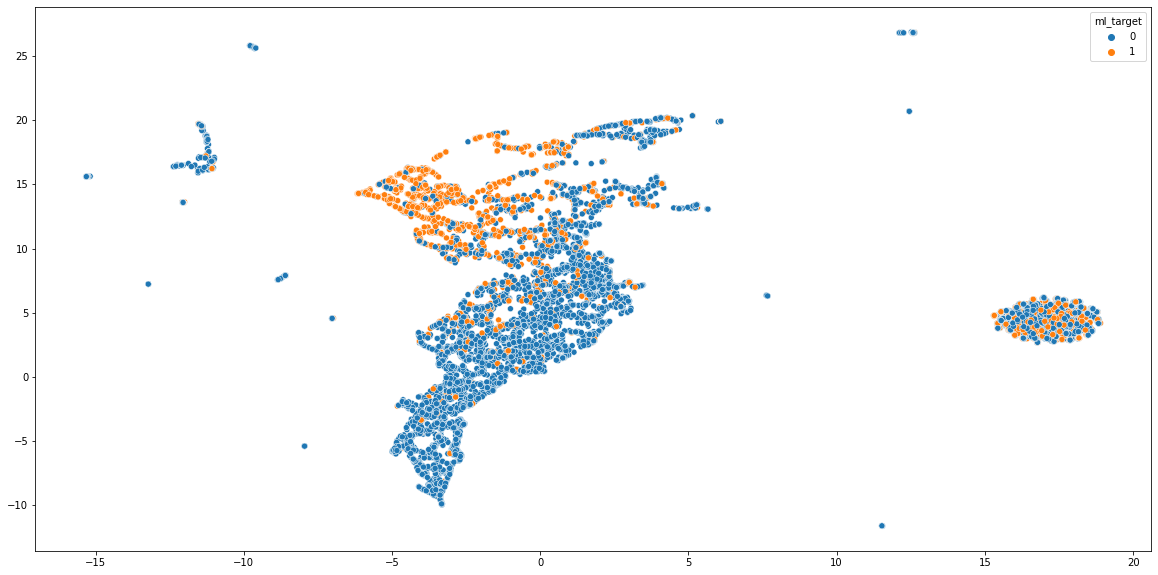

In [34]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target'])

No plot conseguimos identificar que o algoritmo conseguiu separar razoavelmente bem 2 classes, mas deixou um cluster de fora.
Provavelmente, esse cluster extra foi criado devido às amostras e arestas que cortamos para economizar memória.